<a href="https://colab.research.google.com/github/budennovsk/Pandas/blob/master/ES_server_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!pip install catboost
!pip install arch

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
def errors_metrics(y_true, y_pred,name):
    from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error,mean_squared_error,r2_score

    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name}_Mean Absolute Error_средняя абсолютная ошибка: {mae}")

    mse = mean_squared_error(y_true, y_pred)
    print(f"{name}_Mean Squared Error_Среднеквадратичная ошибка: {mse}")

    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{name}_Mean Absolute Percentage Error_Средняя абсолютная процентная ошибка: {mape}")

    r2 = r2_score(y_true, y_pred)
    print(f"{name}_R^2 Score_Коэффициент детерминации: {r2}")


In [52]:
def ensemble_catboost(model_add,model_mul,time_series):
    from catboost import CatBoostRegressor
    import matplotlib.pyplot as plt

    X_train = pd.DataFrame({
        'model1_prediction': model_add.fittedvalues,
        'model2_prediction': model_mul.fittedvalues
    })

    y_train = time_series.loc[:end_train].values

    # Создание и обучение модели CatBoost
    ensemble_model = CatBoostRegressor(iterations=1000, learning_rate=0.01, depth=6)
    ensemble_model.fit(X_train, y_train,verbose=False)

    # Предсказание с помощью ансамбля
    X_test = pd.DataFrame({
        'model1_prediction': model_add.forecast(steps=52),
        'model2_prediction': model_mul.forecast(steps=52)
    })

    ensemble_predictions = ensemble_model.predict(X_test)


    # Построение графика прогнозов ансамбля
    plt.figure(figsize=(12, 6))
    plt.plot(time_series.index, time_series.values, label='True values', color='blue')
    plt.plot(time_series.loc[end_train:].index, ensemble_predictions, label='Ensemble Predictions', color='red')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title('Ensemble Predictions Catboost vs True Values')
    plt.legend()
    plt.show()
    return ensemble_predictions


In [53]:
def ensemble_mean(model_add,model_mul,time_series):
    X_test = pd.DataFrame({
        'model1_prediction': model_add.forecast(steps=52),
        'model2_prediction': model_mul.forecast(steps=52)
    })
    # Создание новой колонки col_mean со средним значением между col1 и col2
    X_test['predict_mean'] = (X_test['model1_prediction'] + X_test['model2_prediction']) / 2

      # Построение графика прогнозов ансамбля
    plt.figure(figsize=(12, 6))
    plt.plot(time_series.index, time_series.values, label='True values', color='blue')
    plt.plot(X_test['predict_mean'], label='Ensemble Predictions', color='red')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title('Ensemble Predictions Mean vs True Values')
    plt.legend()
    plt.show()
    return X_test['predict_mean']


In [54]:
def plt_metrics(model_train,model_test,data,name):

    import random
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    print()
    plt.figure(figsize=(22, 6))
    plt.plot(model_test, label=f'Resid_{name}_test')

    plt.title(f'Resid_{name}_test')
    plt.xlabel('Date')
    plt.ylabel('Resid')
    plt.legend()
    plt.show()
    print()

    plt.figure(figsize=(10, 6))
    model_test.hist(grid=True)
    plt.xlabel('Значения')
    plt.ylabel('Количество')
    plt.title(f'Гистограмма Resid_{name}_test')
    plt.show()
    print()



    from statsmodels.stats.diagnostic import acorr_ljungbox
    box_pierce = acorr_ljungbox(model_test,boxpierce=True,auto_lag=True)
    box_pierce['result'] = box_pierce.apply(lambda row: 'белый шум' if row['lb_pvalue'] >= 0.05 and row['bp_pvalue'] >= 0.05 else 'не белый шум', axis=1)
    print(box_pierce)
    print()
    print()

    import numpy as np
    import statsmodels.api as sm
    from statsmodels.graphics.tsaplots import plot_pacf
    import matplotlib.pyplot as plt

    # Вычисление частичной автокорреляции
    pacf = sm.tsa.stattools.pacf(model_test, nlags=20)

    # Визуализация частичной автокорреляции
    plot_pacf(model_test, lags=20)
    plt.show()

    print(f"Partial Autocorrelation Function (PACF) {name}_test: \n {pacf}")
    print()
    print()

    import numpy as np
    import statsmodels.api as sm
    from statsmodels.graphics.tsaplots import plot_acf
    import matplotlib.pyplot as plt

    # Вычисление полной автокорреляции
    acf = sm.tsa.stattools.acf(model_test, nlags=20)

    # Визуализация полной автокорреляции
    plot_acf(model_test, lags=20)
    plt.show()

    print(f"Autocorrelation Function (ACF): {name}_test \n {acf}")

    print()
    print()

    import numpy as np
    import statsmodels.api as sm
    from statsmodels.tsa.stattools import adfuller

    print('Тест на стационарность Дики-Фуллера (Dickey-Fuller test')
    adf,pvalue,usedlag,nobs,critical_values,icbest = adfuller(model_test)
    print()
    print('kpss_stat', adf)
    print('pvalue', pvalue)
    print('usedlag', usedlag)
    print('nobs', nobs)
    print('critical_values', critical_values)

    print('Results of Dickey-Fuller Test:')

    if pvalue <= 0.05:
        print('I По p-value, ряд стационарен метод Dickey-Fuller Test')
    else:
        print('I По p-value, ряд НЕ стационарен метод Dickey-Fuller Test')

    # check ADF statistic against critical value
    if abs(adf) > abs(max(critical_values.values())):
        print('II По значению ADF статистики, ряд стационарен, метод Dickey-Fuller Test' )
    else:
        print('II По значению ADF Test статистики, ряд НЕ стационарен, метод Dickey-Fuller Test')
    # print('resstore', resstore)

    print()
    print()


    import statsmodels.api as sm
    from statsmodels.tsa.stattools import kpss

    print('Тест на стационарность КПСС (Kwiatkowski-Phillips-Schmidt-Shin test)')
    #KPSS
    kpss_stat,p_value, lags,crit = kpss(model_test,regression = 'ct')
    # check p-value against significance level
    if p_value < 0.05:
        print('I По p-value, ряд НЕ стационарен метод KPSS')
    else:
        print('I По p-value, ряд стационарен метод KPSS')

    # check KPSS statistic against critical value

    if abs(kpss_stat) > abs(max(crit.values())):
        print('II По значению KPSS статистики, ряд НЕ стационарен метод KPSS')
    else:
        print('II По значению KPSS статистики, ряд стационарен метод KPSS')
    print()
    print('kpss_stat', kpss_stat)
    print('p_value', p_value)
    print('lags', lags)
    print('crit', crit)

    print()
    print()

    from arch.unitroot import PhillipsPerron
    # Проведение теста Филлипса-Перрона
    pp = PhillipsPerron(model_test,trend='ct')
    print(pp.summary().as_text())
    print()
    print('Results of Phillips-Perron Test:')
    if pp.pvalue > 0.05:
        print("По p-value, ряд НЕ стационарен методом Phillips-Perron")
    else:
        print("По p-value, ряд стационарен методом Phillips-Perron")
    print()
    print()

    if model_train is not None:
        plt.figure(figsize=(22, 6))
        plt.plot(model_train.resid, label=f'Resid_{name}_train')
        plt.title(f'Resid_{name}_train')
        plt.xlabel('Date')
        plt.ylabel('Resid')
        plt.legend()
        plt.show()
        print()

        plt.figure(figsize=(10, 6))
        model_test.hist(grid=True)
        plt.xlabel('Значения')
        plt.ylabel('Количество')
        plt.title(f'Гистограмма Resid_{name}_train')
        plt.show()
        print()

        from statsmodels.stats.diagnostic import acorr_ljungbox
        box_pierce = acorr_ljungbox(model_train.resid,boxpierce=True,auto_lag=True)
        box_pierce['result'] = box_pierce.apply(lambda row: 'белый шум' if row['lb_pvalue'] >= 0.05 and row['bp_pvalue'] >= 0.05 else 'не белый шум', axis=1)
        print(box_pierce)
        print()
        print()

        import numpy as np
        import statsmodels.api as sm
        from statsmodels.graphics.tsaplots import plot_pacf
        import matplotlib.pyplot as plt

        # Вычисление частичной автокорреляции
        pacf = sm.tsa.stattools.pacf(model_train.resid, nlags=20)

        # Визуализация частичной автокорреляции
        plot_pacf(model_train.resid, lags=20)
        plt.show()

        print(f"Partial Autocorrelation Function (PACF): {name}_train \n {pacf}")
        print()
        print()

        import numpy as np
        import statsmodels.api as sm
        from statsmodels.graphics.tsaplots import plot_acf
        import matplotlib.pyplot as plt

        # Вычисление полной автокорреляции
        acf = sm.tsa.stattools.acf(model_train.resid, nlags=20)

        # Визуализация полной автокорреляции
        plot_acf(model_train.resid, lags=20)
        plt.show()

        print(f"Autocorrelation Function (ACF): {name}_train \n {acf}")

        print()
        print()

        import numpy as np
        import statsmodels.api as sm
        from statsmodels.tsa.stattools import adfuller

        print('Тест на стационарность Дики-Фуллера (Dickey-Fuller test')
        adf,pvalue,usedlag,nobs,critical_values,icbest = adfuller(model_train.resid)
        print()
        print('kpss_stat', adf)
        print('pvalue', pvalue)
        print('usedlag', usedlag)
        print('nobs', nobs)
        print('critical_values', critical_values)

        print('Results of Dickey-Fuller Test:')

        if pvalue <= 0.05:
            print('I По p-value, ряд стационарен метод Dickey-Fuller Test')
        else:
            print('I По p-value, ряд НЕ стационарен метод Dickey-Fuller Test')

        # check ADF statistic against critical value
        if abs(adf) > abs(max(critical_values.values())):
            print('II По значению ADF статистики, ряд стационарен, метод Dickey-Fuller Test' )
        else:
            print('II По значению ADF Test статистики, ряд НЕ стационарен, метод Dickey-Fuller Test')
        # print('resstore', resstore)

        print()
        print()


        import statsmodels.api as sm
        from statsmodels.tsa.stattools import kpss

        print('Тест на стационарность КПСС (Kwiatkowski-Phillips-Schmidt-Shin test)')
        #KPSS
        kpss_stat,p_value, lags,crit = kpss(model_train.resid,regression = 'ct')
        # check p-value against significance level
        if p_value < 0.05:
            print('I По p-value, ряд НЕ стационарен метод KPSS')
        else:
            print('I По p-value, ряд стационарен метод KPSS')

        # check KPSS statistic against critical value

        if abs(kpss_stat) > abs(max(crit.values())):
            print('II По значению KPSS статистики, ряд НЕ стационарен метод KPSS')
        else:
            print('II По значению KPSS статистики, ряд стационарен метод KPSS')
        print()
        print('kpss_stat', kpss_stat)
        print('p_value', p_value)
        print('lags', lags)
        print('crit', crit)

        print()
        print()

        from arch.unitroot import PhillipsPerron
        # Проведение теста Филлипса-Перрона
        pp = PhillipsPerron(model_train.resid,trend='ct')
        print(pp.summary().as_text())
        print()
        print('Results of Phillips-Perron Test:')
        if pp.pvalue > 0.05:
            print("По p-value, ряд НЕ стационарен методом Phillips-Perron")
        else:
            print("По p-value, ряд стационарен методом Phillips-Perron")
        print()
        print()


In [55]:
from scipy.optimize import minimize
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

# Определите функцию потерь (MAE)
def mae_loss(params, time_series, end_train, test_data):


    # Распаковка параметров
    smoothing_level, smoothing_trend, smoothing_seasonal = params

    # Создание модели с заданными параметрами
    model = ExponentialSmoothing(
        time_series.loc[:end_train],
        trend="add",
        seasonal='add',
        seasonal_periods=52
    ).fit(smoothing_level=smoothing_level,
        smoothing_trend=smoothing_trend,
        smoothing_seasonal=smoothing_seasonal)

    # Делаем прогнозы
    forecast = model.forecast(52)

    # Вычисляем MAE
    mae = np.mean(np.abs(forecast - test_data))

    return mae

In [56]:
def model_Exponential_Smoothing(time_series):
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    import matplotlib.pyplot as plt
    from statsmodels.tsa.seasonal import STL
    import numpy as np

    # end_train = '2023-01-01 23:59:59'
    # end_train_26 = '2023-07-01 23:59:59'
    end_train = '2023-12-24 23:59:59'
    end_train_26 = '2023-12-24 23:59:59'



    additive_model = ExponentialSmoothing(
        time_series.loc[:end_train],
        trend="add",
        seasonal='add',
        seasonal_periods=52
        # dates = time_series[:end_train].index
    ).fit()
    # initial_params = [0.5, 0.5, 0.5]

    # # Минимизация ошибки MAE
    # result = minimize(mae_loss, initial_params, args=(time_series, end_train, time_series.loc[end_train:]), method='Nelder-Mead')
    # # Распаковка оптимизированных параметров
    # print(result.x)
    # smoothing_level_opt, smoothing_trend_opt, smoothing_seasonal_opt = result.x


    # additive_model = ExponentialSmoothing(
    #     time_series.loc[:end_train],
    #     trend="add",
    #     seasonal='add',
    #     seasonal_periods=52
    # ).fit(smoothing_level=smoothing_level_opt,
    #       smoothing_trend=smoothing_trend_opt,
    #       smoothing_seasonal=smoothing_seasonal_opt)


    additive_model_26 = ExponentialSmoothing(
        time_series.loc[:end_train_26],
        trend="add",
        seasonal='add',
        seasonal_periods=52
        # dates = time_series[:end_train].index
    ).fit()




    states1 = pd.DataFrame(
    np.c_[additive_model.level, additive_model.trend, additive_model.season],
    columns=["level", "slope", "seasonal"],
    index= time_series[:end_train].index)

    # Мультипликативная модель
    multiplicative_model = ExponentialSmoothing(
        time_series.loc[:end_train],
        trend="mul",
        seasonal='mul',
        seasonal_periods=52
        # dates = time_series[:end_train].index
    ).fit()

    multiplicative_model_26 = ExponentialSmoothing(
        time_series.loc[:end_train_26],
        trend="mul",
        seasonal='mul',
        seasonal_periods=52
        # dates = time_series[:end_train].index
    ).fit()

    states2 = pd.DataFrame(
    np.c_[multiplicative_model.level, multiplicative_model.trend, multiplicative_model.season],
    columns=["level", "slope", "seasonal"],
    index= time_series[:end_train].index)

    # Делаем прогнозы
    additive_forecast = additive_model.forecast(52)
    additive_forecast_сonfidence= additive_model.simulate(52, repetitions=100, error="add")
    additive_forecast_26 = additive_model_26.forecast(30)


    multiplicative_forecast = multiplicative_model.forecast(52)
    multiplicative_forecast_сonfidence= multiplicative_model.simulate(52, repetitions=100, error="mul")
    multiplicative_forecast_26 = multiplicative_model_26.forecast(30)

    # additive_model_resid = time_series.loc[end_train:] - additive_forecast

    # multiplicative_model_resid = time_series.loc[end_train:] - multiplicative_forecast


    fig, [[ax1, ax4], [ax2, ax5], [ax3, ax6]] = plt.subplots(3, 2, figsize=(22, 12))

    states1[["level"]].plot(ax=ax1)
    ax1.set_title("additive модель")
    states1[["slope"]].plot(ax=ax2)
    ax2.set_title("additive модель")
    states1[["seasonal"]].plot(ax=ax3)
    ax3.set_title("additive модель")
    states2[["level"]].plot(ax=ax4)
    ax4.set_title("multiplicative_model")
    states2[["slope"]].plot(ax=ax5)
    ax5.set_title("multiplicative_model")
    states2[["seasonal"]].plot(ax=ax6)
    ax6.set_title("multiplicative_model")
    # Установка заголовка для всего подмножества графиков
    fig.suptitle('Тренд,сезонность, наклон выдает сама модель при обучении ES', fontsize=16)
    fig.tight_layout()
    plt.show()
    print()

    stl = STL(time_series.loc[:end_train], seasonal=13)
    result = stl.fit()

    fig, axes = plt.subplots(4, 1, sharex=False)
    fig.suptitle('STL Decomposition', fontsize=16)
    fig.set_size_inches(22, 12)

    # График исходных данных
    axes[0].plot(result.observed)
    axes[0].set_title('Observed')
    axes[0].grid(True)

    # График тренда
    axes[1].plot(result.trend)
    axes[1].set_title('Trend')
    axes[1].grid(True)

    # График сезонности
    axes[2].plot(result.seasonal)
    axes[2].set_title('Seasonality')
    axes[2].grid(True)

    # График остатка
    axes[3].plot(result.resid)
    axes[3].set_title('Residuals')
    axes[3].grid(True)

    # Добавляем пространство между графиками
    plt.subplots_adjust(hspace=0.5)

    # Показываем графики
    plt.show()
    print()
    # Визуализация
    plt.figure(figsize=(22, 6))
    plt.plot(time_series)
    plt.plot(additive_forecast_сonfidence, linestyle="-", alpha=0.05, color="grey") #alpha=0.05 label='Additive Forecast + доверитленые интервалы '
    plt.legend().remove()
    plt.plot(additive_forecast, label='Additive Forecast', linestyle='--')
    plt.plot(additive_model.fittedvalues, label='Additive Train', linestyle='--')
    plt.title('Additive Forecast + доверитленые интервалы')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

     # Визуализация
    plt.figure(figsize=(22, 6))
    plt.plot(time_series)
    plt.plot(multiplicative_forecast_сonfidence, linestyle="-", alpha=0.05, color="grey") #alpha=0.05 label='Additive Forecast + доверитленые интервалы '
    plt.legend().remove()
    plt.plot(multiplicative_forecast, label='multiplicative Forecast', linestyle='--')
    plt.plot(multiplicative_model.fittedvalues, label='multiplicative Train', linestyle='--')
    plt.title('multiplicative Forecast + доверитленые интервалы')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

    # ensemble_predictions_catboost = ensemble_catboost(additive_model,multiplicative_model, time_series)
    ensemble_predictions_mean = ensemble_mean(additive_model,multiplicative_model, time_series)
    # ensemble_model_resid_catboost = time_series.loc[end_train:] - ensemble_predictions_catboost
    # ensemble_model_resid_mean = time_series.loc[end_train:] - ensemble_predictions_mean


    # Визуализация
    plt.figure(figsize=(22, 6))
    plt.plot(time_series, label='Actual Sales')
    plt.plot(additive_forecast, label='Additive Forecast', linestyle='--') #alpha=0.05
    plt.plot(multiplicative_forecast, label='Multiplicative Forecast', linestyle='--')
    plt.plot(additive_model.fittedvalues, label='Additive Train', linestyle='--')#,color='green')
    plt.plot(multiplicative_model.fittedvalues, label='Multiplicative Train', linestyle='--')#,color='orange')
    # plt.plot(time_series.loc[end_train:].index,ensemble_predictions_catboost, label='Ensemble Forecast Catboost', linestyle='--', color='red')#,color='orange')
    plt.plot(ensemble_predictions_mean, label='Ensemble Forecast Mean', linestyle='--', color='blue')#,color='orange')

    plt.title('Souvenir Sales Forecast Using Holt-Winters Method')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()
    print()
    # Визуализация
    plt.figure(figsize=(22, 6))
    plt.plot(time_series[end_train:], label='Actual Sales')
    plt.plot(additive_forecast, label='Additive Forecast', linestyle='--') #alpha=0.05
    plt.plot(multiplicative_forecast, label='Multiplicative Forecast', linestyle='--')
    # plt.plot(time_series.loc[end_train:].index,ensemble_predictions_catboost, label='Ensemble Forecast Catboost', linestyle='--', color='red')#,color='orange')
    plt.plot(ensemble_predictions_mean, label='Ensemble Forecast Mean', linestyle='--', color='blue')#,color='orange')

    plt.title('Souvenir Sales Forecast Using Holt-Winters Method')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

    errors_metrics(time_series[:end_train], additive_model.fittedvalues,'Train_additive_model')
    print('______________________')
    errors_metrics(time_series[:end_train], multiplicative_model.fittedvalues,'Train_multiplicative_model')
    # print('______________________')
    # errors_metrics(time_series[end_train:], additive_forecast,'Test_additive_model')
    # print('______________________')
    # errors_metrics(time_series[end_train:], multiplicative_forecast,'Test_multiplicative_model')
    # print('______________________')
    # errors_metrics(time_series[end_train:], ensemble_predictions_catboost,'Ensemble_model_catboost')
    # print('______________________')
    # errors_metrics(time_series[end_train:], ensemble_predictions_mean,'Ensemble_model_mean')



    print()
     # Визуализация
    plt.figure(figsize=(22, 6))
    plt.plot(time_series, label='Actual Sales')
    plt.plot(additive_forecast_26, label='Additive Forecast_26', linestyle='--') #alpha=0.05
    plt.plot(multiplicative_forecast_26, label='Multiplicative Forecast_26', linestyle='--')
    plt.plot(additive_model_26.fittedvalues, label='Additive Train_26', linestyle='--')#,color='green')
    plt.plot(multiplicative_model_26.fittedvalues, label='Multiplicative Train_25', linestyle='--')#,color='orange')

    plt.title('Souvenir Sales Forecast Using Holt-Winters Method_26')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()



    # plt_metrics(additive_model,additive_model_resid,time_series,'Additive_model')

    # plt_metrics(multiplicative_model,multiplicative_model_resid,time_series,'Multiplicative_model')
    # plt_metrics(None,ensemble_model_resid_catboost,time_series,'Ensemble_model_catboost')
    # plt_metrics(None,ensemble_model_resid_mean,time_series,'Ensemble_model_Mean')



In [57]:
def rolling(time_series):
    win = 52
    moving_avg = time_series.rolling(window=win).mean()
    moving_std = time_series.rolling(window=win).std()
    return moving_avg, moving_std, win

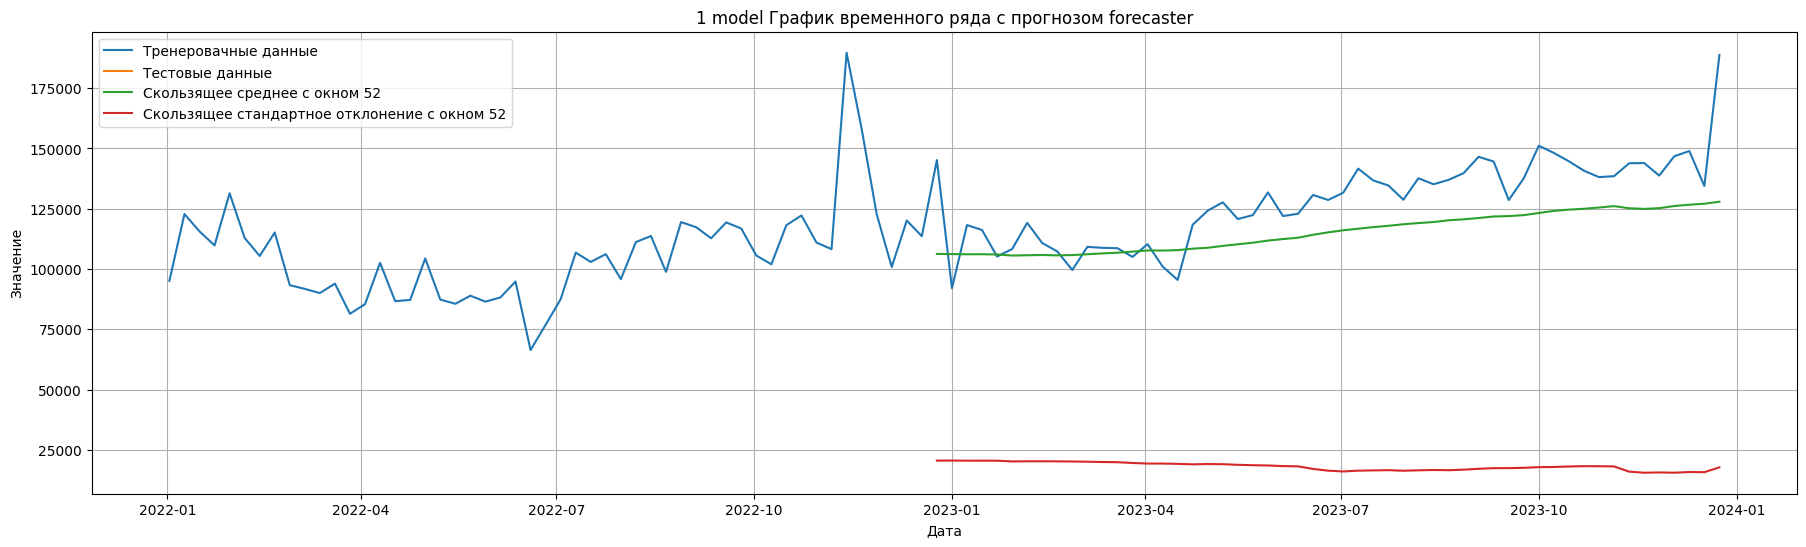

2022-01-02     95112.365
2022-01-09    122798.495
2022-01-16    115615.765
2022-01-23    109786.305
2022-01-30    131394.165
                 ...    
2023-11-26    138732.385
2023-12-03    146740.220
2023-12-10    148920.275
2023-12-17    134438.150
2023-12-24    188733.425
Freq: W-SUN, Name: SALES VOL, Length: 104, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


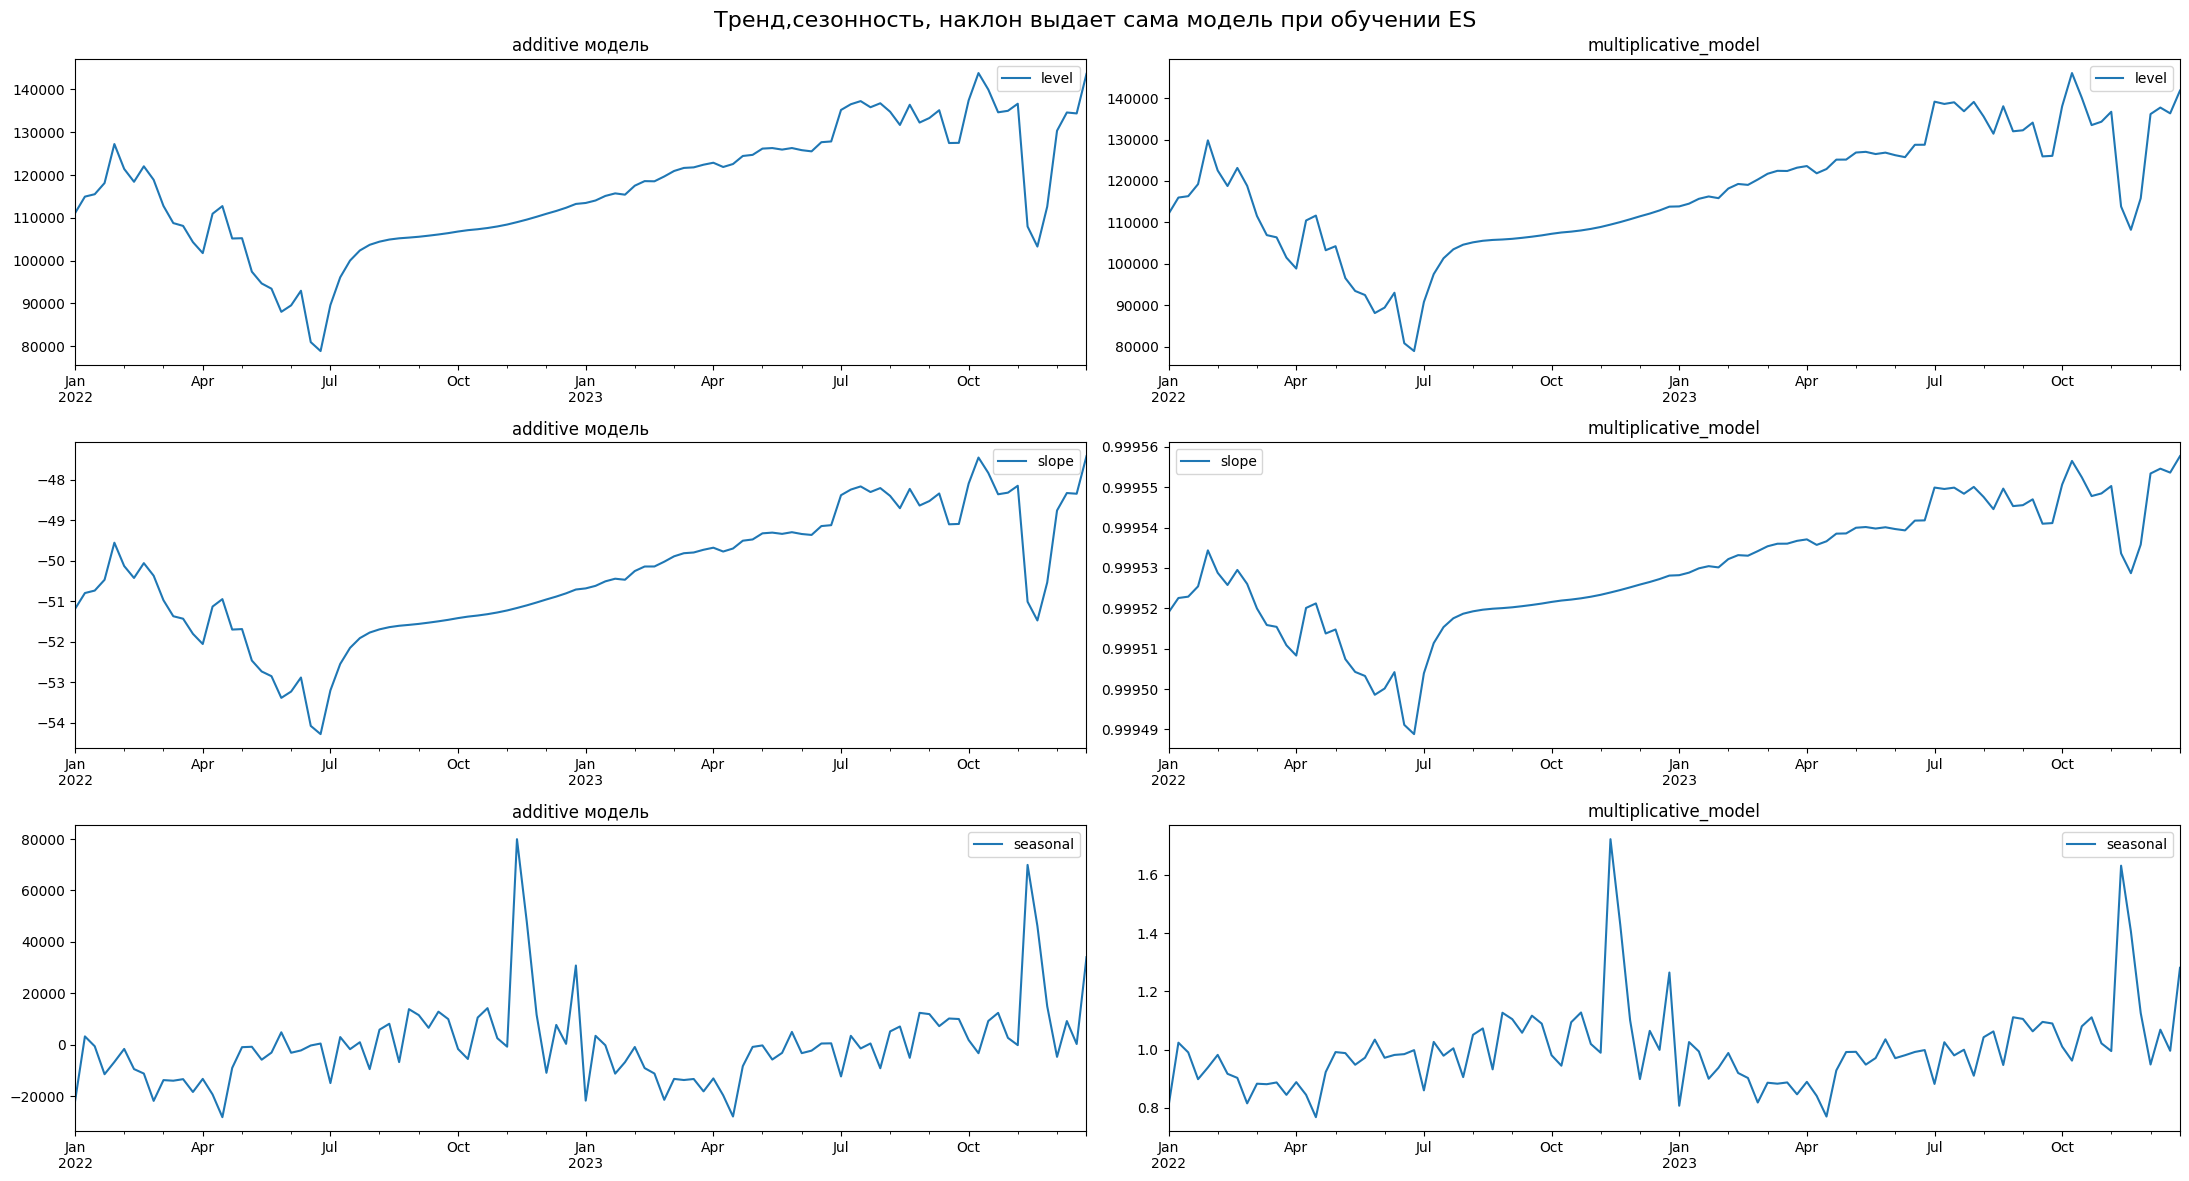

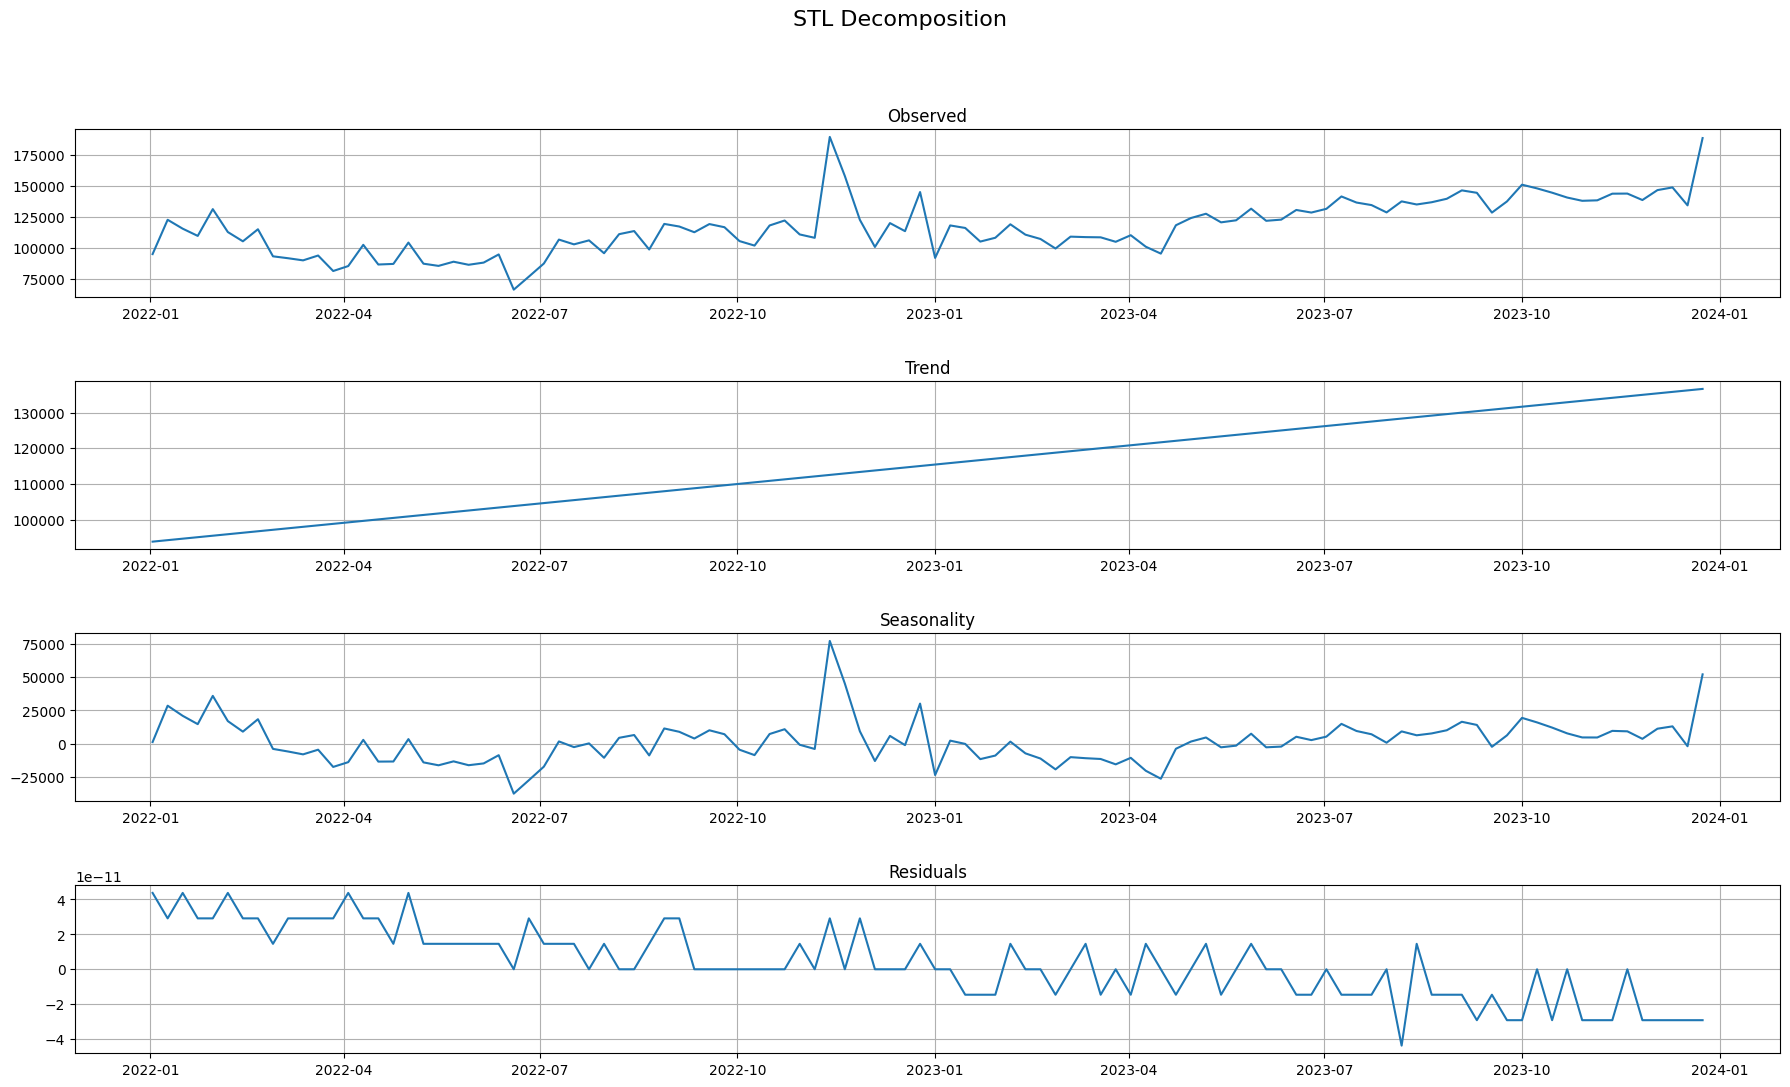

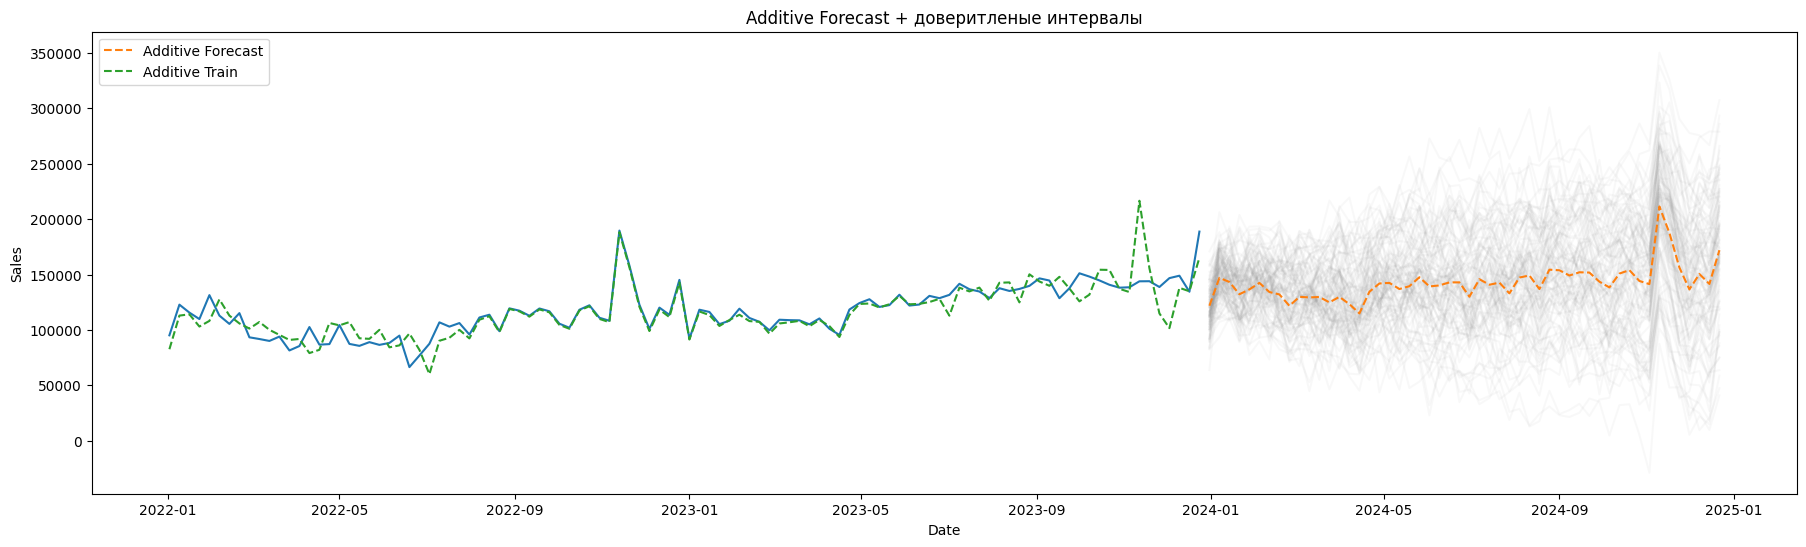

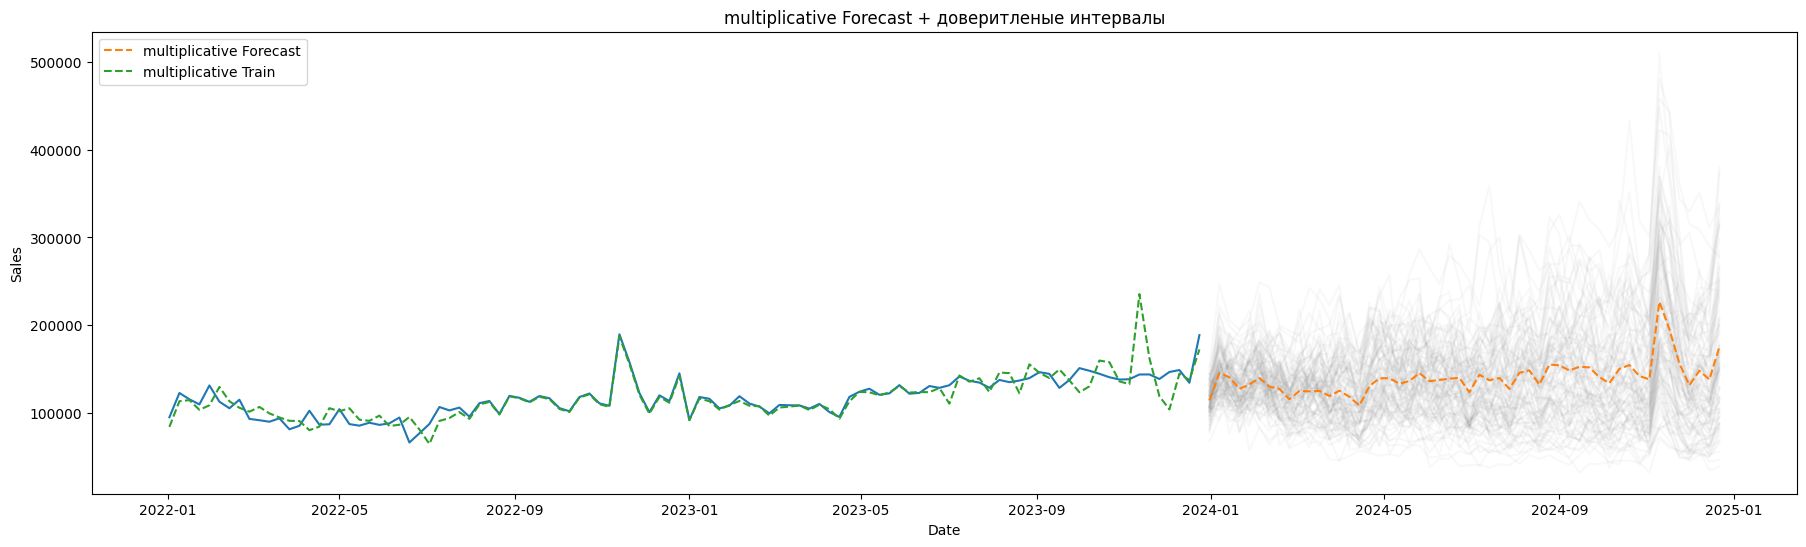

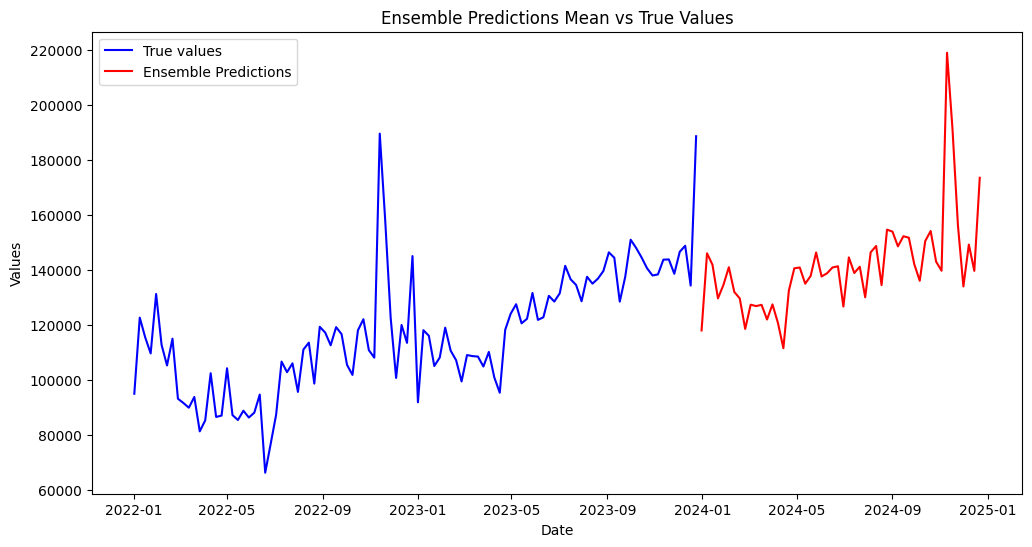

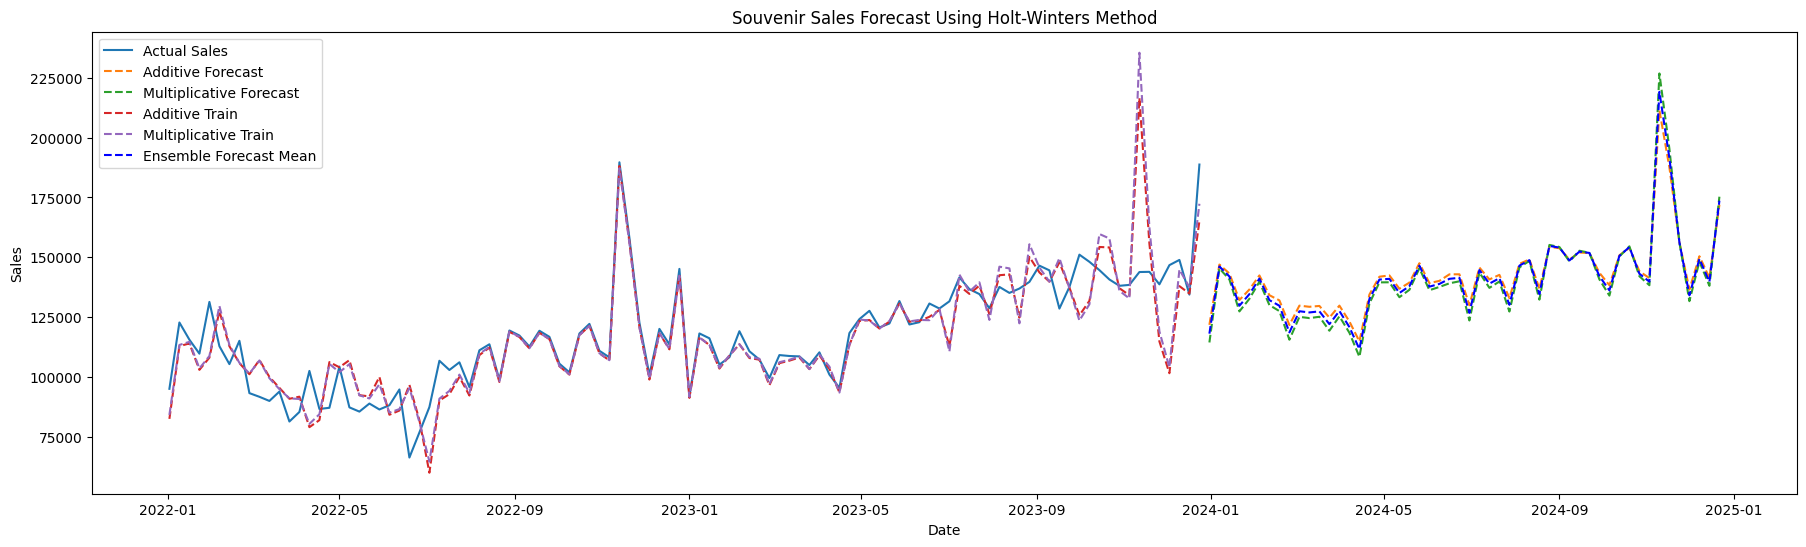

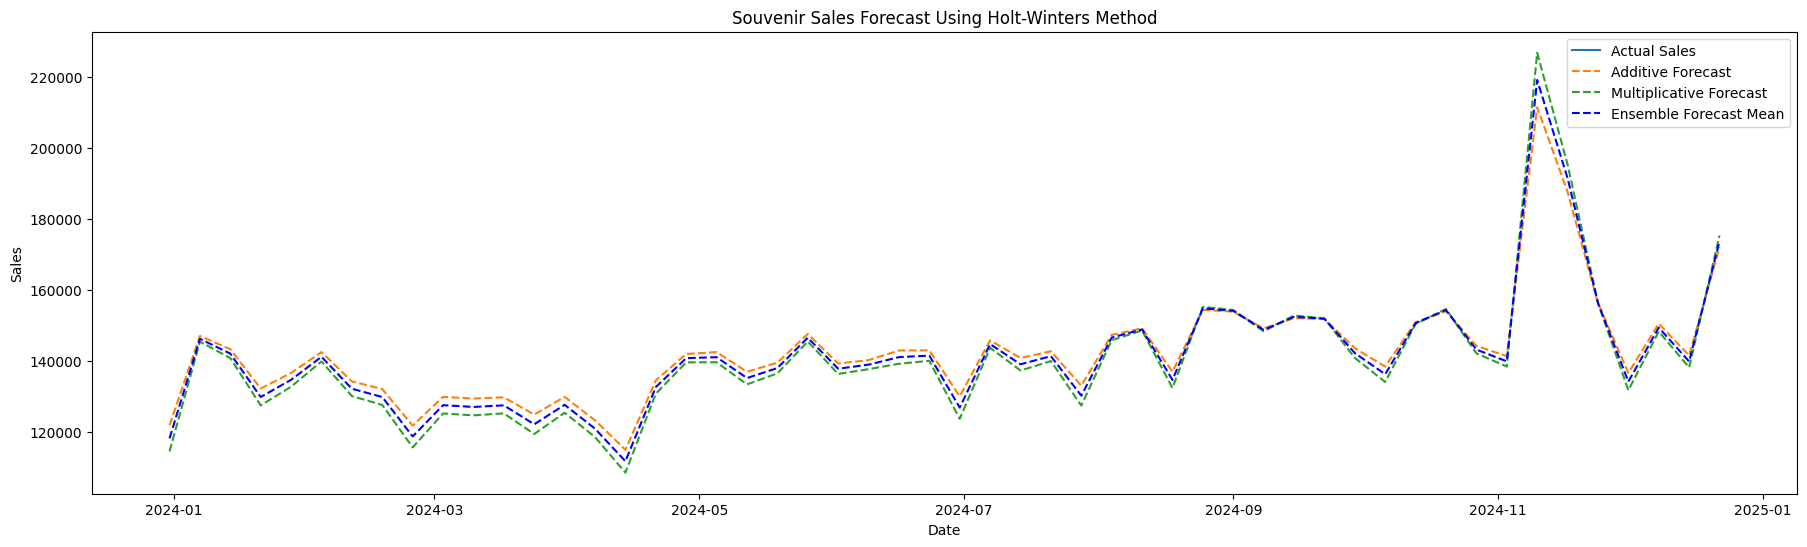

Train_additive_model_Mean Absolute Error_средняя абсолютная ошибка: 7386.077183140558
Train_additive_model_Mean Squared Error_Среднеквадратичная ошибка: 161154746.18118653
Train_additive_model_Mean Absolute Percentage Error_Средняя абсолютная процентная ошибка: 0.06489544431623326
Train_additive_model_R^2 Score_Коэффициент детерминации: 0.6645487218524881
______________________
Train_multiplicative_model_Mean Absolute Error_средняя абсолютная ошибка: 7528.746840290969
Train_multiplicative_model_Mean Squared Error_Среднеквадратичная ошибка: 187563236.01313803
Train_multiplicative_model_Mean Absolute Percentage Error_Средняя абсолютная процентная ошибка: 0.06501236250529853
Train_multiplicative_model_R^2 Score_Коэффициент детерминации: 0.6095781927306603



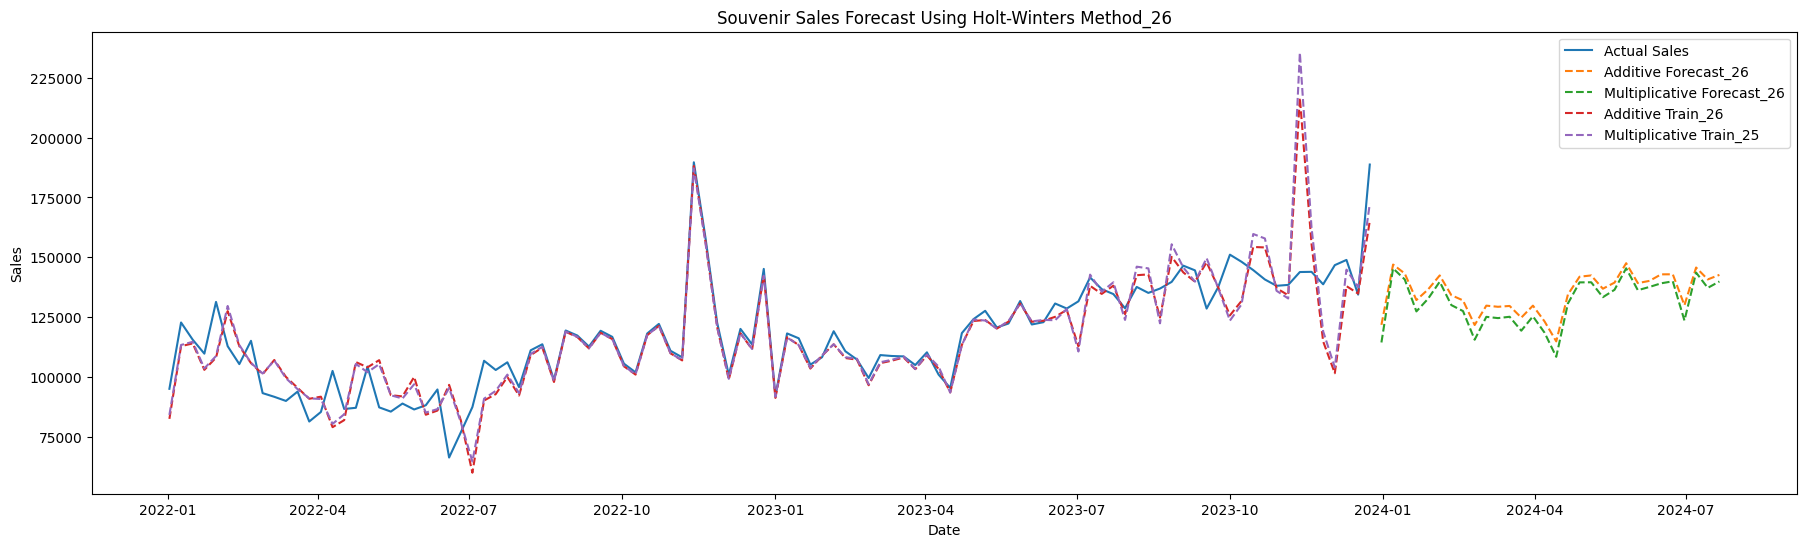

In [58]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from math import sqrt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

end_train = '2023-12-24 23:59:59'
end_train_26 = '2023-12-24 23:59:59'



# Замените 'file.xlsx' на путь к вашему файлу Excel
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/zvezda/Server_zvezda/Dataset/test1.xlsx',
                   )
data['Time']= pd.date_range(start='2022-01', freq='W',periods=104)

data = data.set_index('Time')
data = data.asfreq('W')
data.index.name=None
data.drop(['Week_Year'],inplace=True, axis=1)
data = data['SALES VOL']

# Calculate the moving average with window size 3
moving_avg, moving_std, win = rolling(data)


# Добавление прогноза на график
plt.figure(figsize=(22, 6))
plt.plot(data.index[data.index<=end_train], data[:end_train], label='Тренеровачные данные')
plt.plot(data.index[data.index>=end_train], data[end_train:],label='Тестовые данные')
plt.plot(moving_avg,label=f'Скользящее среднее с окном {win}')
plt.plot(moving_std,label=f'Скользящее стандартное отклонение с окном {win}')

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('1 model График временного ряда с прогнозом forecaster')
plt.legend()
plt.grid(True)
plt.show()
print(data)



model_Exponential_Smoothing(data)
